### ToDo
* changing resource state 
* changing setup for each op 
    * may not required as you have the current operation with the req setup
    * and we do not consider setup times.
* monitoring the basics
* Material (Charge, Qualität, usw)
* Vorgänger (und Nachfolger) auf der Maschine speichern (vollständige Historie) --> Erweiterung: Stack/Queue mit "x Elementen" oder einen "x Zeitraum"
* alternative Maschine aus Maschinengruppe nutzen (optional?)
* Giffler - offene Operationen für die Inferencing
* run-event selbst bauen warten bis zum Endschritt 

In [1]:
from plan.GifflerThompson import GifflerThompson
from plan.HodgsonMoore import HodgsonMooreAlgorithm
from factory.Operation import Operation
from simulation.Simulator import Simulator
from causal.causal_model import CausalModel
from generators.jobs_data_generator import JobsDataGenerator
import random

import pandas as pd
# Beispielhafte Datenstruktur
template_jobs_data = [
    ['p1', 1, 'a1', 30, 4],
    ['p1', 2, 'a2', 45, 4],
    ['p1', 3, 'a1', 15, 4],
    ['p1', 4, 'a3', 15, -1],
    ['p2', 1, 'a1', 15, 3],
    ['p2', 2, 'a4', 45, 3],
    ['p2', 3, 'a3', 15, 5],
    ['p2', 4, 'a2', 30, 5],
    ['p2', 5, 'a4', 15, -1],
    
#    ['p1', 1, 'a1', 17, 2],
#    ['p1', 2, 'a2', 30, 4],
#    ['p1', 3, 'a3', 14, 4],
#    ['p1', 4, 'a4', 15, 5],
#    ['p1', 5, 'a5', 25, -1],
#    ['p2', 1, 'a1', 13, 3],
#    ['p2', 2, 'a3', 15, 3],
#    ['p2', 3, 'a2', 10, 4],
#    ['p2', 4, 'a6', 20, -1],
]

generator = JobsDataGenerator(template_jobs_data)
num_instances = 500  # Number of new instances to generate
relation = {'p1': 0.5, 'p2': 0.5}  # Relation of each product type

jobs_data = generator.generate_jobs_data(num_instances, relation)

# Maschinenpools definieren
# id, number, tools 
machine_pools_data = [
    ['a1', 4, [1,2,3]],
    ['a2', 4, [1,2,3]],
    ['a3', 4, [1,2,3]],
    ['a4', 4, [1,2,3]],
#    ['a5', 1, [1,2,3]],
#    ['a6', 1, [1,2,3]],
]

# Konvertiere die jobs_data in Operation-Objekte
operations_causal = [Operation(*data) for data in jobs_data]
operations_non_causal = [Operation(*data) for data in jobs_data]

# Define a priority rule
def calculate_dynamic_priority(operation) -> int:
    # Priorität basierend auf der geplanten Startzeit der Vorgängeraufgaben
    if not operation.predecessor_operations:
        return operation.plan_start if operation.plan_start is not None else 0
    else:
        return max(pred.plan_start for pred in operation.predecessor_operations) + operation.duration

# causal model
observed_data = []
csv_file = 'data/observed_data.csv'
model = CausalModel(csv_file=csv_file)
# Causal model for simulation
# define an inference rule    
def simulation_inference(operation: Operation) -> int:
 
    # 1. Preperation step
    has_lots_operations = len(operation.predecessor_operations) > 1
    is_shorter_than_15 =  operation.plan_duration < 15
    filtered_pools = [pool for pool in sim.pools.values() if pool.group == operation.machine.group and pool.id != operation.machine.id]
    one_working = any(pool.current_operation is not None for pool in filtered_pools) 
    
    # 2. Infer step
    duration_factor = model.infer_duration(True, has_lots_operations, is_shorter_than_15, one_working)

    # 3. Calculation step
    new_duration = round(operation.duration * duration_factor,0)
    
    # Save for causal learning
    observed_data.append([has_lots_operations, is_shorter_than_15, one_working, duration_factor])
    
    print(f"Operation duration was: {operation.duration} and has been changed to {new_duration}")
    return new_duration

# Causal model for planning
# define an inference rule    
def plan_inference(operation: Operation) -> int:
    
    # 1. Preperation step
    has_lots_operations = len(operation.predecessor_operations) > 1
    is_shorter_than_15 =  operation.plan_duration < 15
    
    #TODO add the free resources from the gt.schedule
    # gt.schedule
    
    #filtered_pools = [pool for pool in sim.pools.values() if pool.group == operation.machine.group and pool.id != operation.machine.id]
    #one_working = any(pool.current_operation is not None for pool in filtered_pools) 
    one_working = random.choice([True, False])
    # 2. Infer step
    duration_factor = model.infer_duration(False, has_lots_operations, is_shorter_than_15, one_working)

    # 3. Calculation step
    new_duration = round(operation.duration * duration_factor, 0)
    return new_duration

# Causal model for planning
# define an inference rule    
def plan_inference_non(operation: Operation) -> int:
    return operation.duration

#hodgens = HodgsonMooreAlgorithm()
#hodgens_schedule = hodgens.schedule_jobs(operations_non_causal, machine_pools_data)

# Führe den Giffler Thompson Algorithmus aus
gt = GifflerThompson(calculate_dynamic_priority, plan_inference)
gt_causal_schedule = gt.giffen_thompson(operations_causal, machine_pools_data)

# Führe den Giffler Thompson Algorithmus aus
non_causal = GifflerThompson(calculate_dynamic_priority, plan_inference_non)
gt_non_causal_schedule = non_causal.giffen_thompson(operations_non_causal, machine_pools_data)


/home/marvin/repo/PlanCausal/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 4/1000000 [00:00<1:23:35, 199.40it/s]


Inferred duration factor: 0.9


  0%|          | 4/1000000 [00:00<1:19:45, 208.96it/s]


In [6]:
from simulation.Simulator import Simulator
from simulation.Monitoring.BasicMonitor import monitorResource
from functools import partial

# array to store monitored data
data = []

# resource monitor [pre , post] execution
monitor = [None, partial(monitorResource, data)]

sim = Simulator(machine_pools_data
                , operations_non_causal
                , monitor
                , simulation_inference)

sim.env.run(12000)

1740
2250
1890
2295
2580
1935
2595
3510
3540
3390
2385
3405
4215
4245
3495
4305
3510
4350
3585
4425
3600
4470
3690
2520
3720
4560
4590
3765
4635
3780
4680
0
0
45
30
2670
90
105
120
150
165
210
195
255
255
315
270
360
345
225
360
450
2760
420
270
435
540
2775
510
315
525
660
2790
585
735
615
780
690
840
720
885
795
450
810
975
2835
870
540
900
1080
2865
960
1170
975
1215
1035
675
1050
1290
2910
1125
720
1140
1380
2925
1185
810
1230
1485
2955
1275
1575
1290
1620
1350
1680
1365
1725
1425
990
1440
1800
3015
1500
1080
1530
1890
3045
1575
1170
1605
1980
3060
1665
1215
1680
2100
3075
1755
2175
1785
2220
1830
1350
1845
2325
3120
1905
1395
1920
2415
3150
1980
2490
2010
2535
2070
1575
2115
2610
3195
2130
2685
2160
2730
2235
2805
2250
2850
2310
2895
2325
2940
2415
3015
2445
3060
2505
1800
2535
3135
3285
2595
1890
2610
3240
3300
2670
1980
2685
3345
3375
2745
3420
2775
3465
2850
3540
2865
3585
2940
3660
2955
3705
3030
2160
3060
3780
3810
3105
3855
3135
3900
3210
2295
3225
3990
4020
3300
2295
3315
4

## Some statistics to compare the plan

In [7]:
import pandas as pd

def calculate_makespan(df_schedule, schedule_name):
    # Convert the list of operation objects to a DataFrame
    

    # Calculate start and end times for each job
    grouped_schedule = df_schedule.groupby('job_id').agg({'start_time': 'min', 'end_time': 'max'})

    # Calculate the makespan for each job
    grouped_schedule['makespan'] = grouped_schedule['end_time'] - grouped_schedule['start_time']

    # Calculate the average makespan across all jobs
    average_makespan = grouped_schedule['makespan'].mean()

    # Output the results with the schedule name
    print(f"The average makespan across all products in the {schedule_name} schedule is: {average_makespan} time units.")

# Example usage with named schedules
calculate_makespan(pd.DataFrame([op.to_dict() for op in gt_non_causal_schedule]), 'NonCausal')
calculate_makespan(pd.DataFrame([op.to_dict() for op in gt_causal_schedule]), 'Causal')
calculate_makespan(pd.DataFrame([op.to_dict_sim() for op in sim.schedule]), 'Sim')



The average makespan across all products in the NonCausal schedule is: 1209.39 time units.
The average makespan across all products in the Causal schedule is: 1409.414 time units.
The average makespan across all products in the Sim schedule is: 1464.852 time units.


In [ ]:
#df_observed_data = pd.DataFrame(observed_data, columns=['has_lots_operations','is_shorter_than_15','one_working', 'duration'])
#df_observed_data.to_csv("data/observed_data.csv")

GT without causal

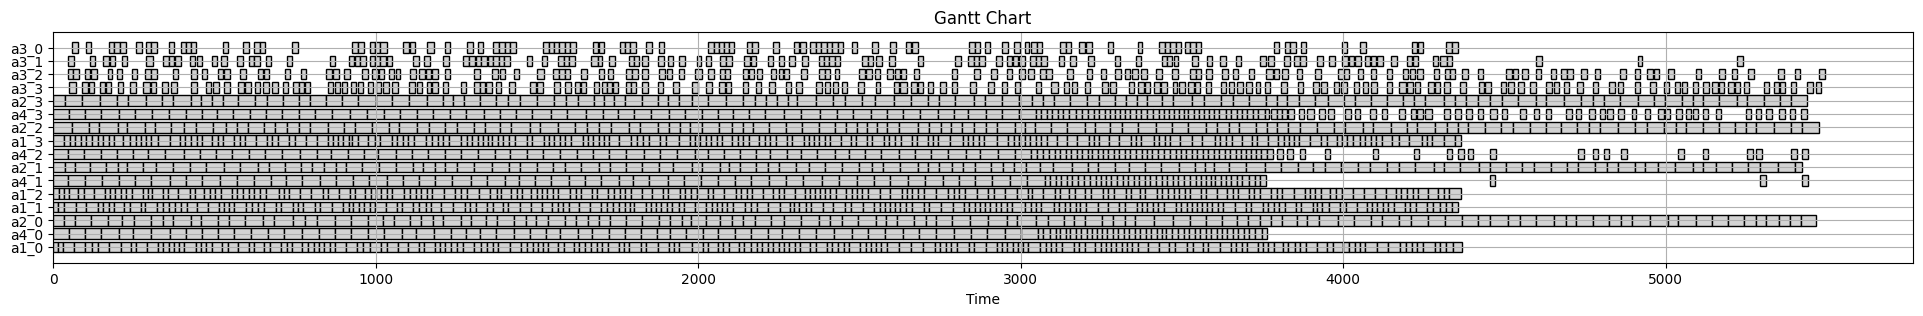

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import math

# Daten in ein DataFrame konvertieren
df = pd.DataFrame([p.to_dict() for p in gt_causal_schedule])

size_height = math.ceil(df["machine"].count().itemsize / 3)
# Gantt-Diagramm erstellen
fig, ax = plt.subplots(figsize=(24, size_height))

# Maschinen als y-Werte für die Balken
machines = df['machine'].unique()
machine_to_y = {machine: i for i, machine in enumerate(machines)}

# Iteriere über jede Zeile des DataFrames
for i, row in df.iterrows():
    start = row['start_time']
    duration = row['plan_duration']
    job_id = row['job_id']
    task_id = row['operation_id']
    machine = row['machine']
    label = f'{job_id} {task_id}'

    # Stelle die Aufgabe als Balken im Diagramm dar
    ax.barh(y=machine_to_y[machine], left=start, width=duration, height=0.8, align='center', color='lightgrey', edgecolor='black')
    
    # Text in den Balken einfügen
    #ax.text(x=start + duration / 2, y=machine_to_y[machine], s=label, va='center', ha='center', color='black')

# Diagramm formatieren
ax.set_xlabel('Time')
ax.set_yticks(list(machine_to_y.values()))
ax.set_yticklabels(list(machine_to_y.keys()))
ax.set_title('Gantt Chart')

# Grid anzeigen
ax.grid(True)

# Legende entfernen, da sie nicht mehr notwendig ist
# Handles und Labels der Legende deduplizieren
# handles, labels = plt.gca().get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys())

# Diagramm anzeigen
plt.show()


Sim result

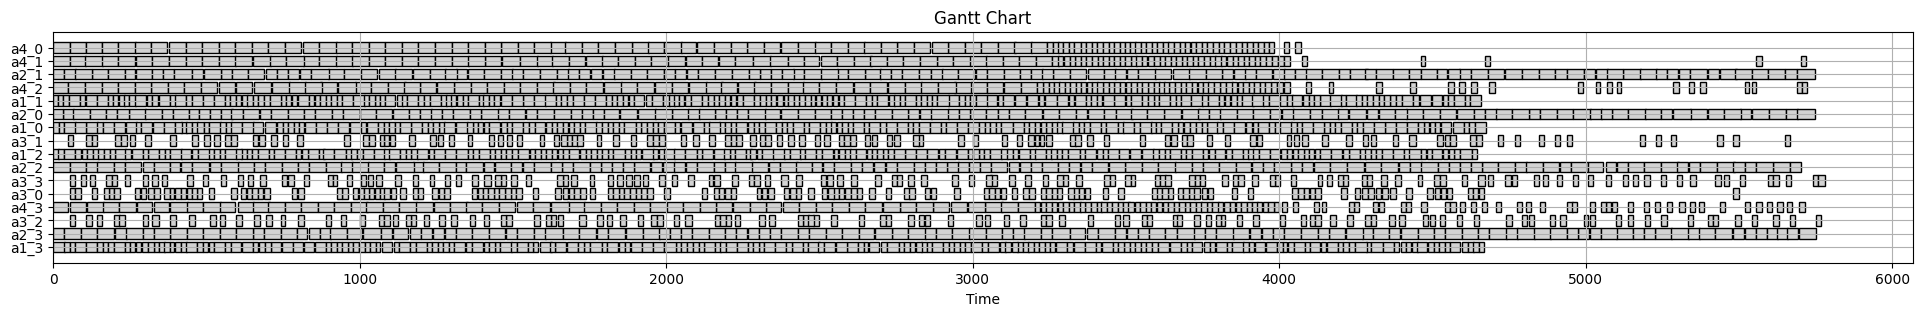

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import math

# Daten in ein DataFrame konvertieren
df = pd.DataFrame([op.to_dict_sim() for op in sim.schedule])

size_height = math.ceil(df["machine"].count().itemsize / 3)
# Gantt-Diagramm erstellen
fig, ax = plt.subplots(figsize=(24, size_height))

# Maschinen als y-Werte für die Balken
machines = df['machine'].unique()
machine_to_y = {machine: i for i, machine in enumerate(machines)}

# Iteriere über jede Zeile des DataFrames
for i, row in df.iterrows():
    start = row['start_time']
    duration = row['duration']
    job_id = row['job_id']
    task_id = row['operation_id']
    machine = row['machine']
    label = f'{job_id} {task_id}'

    # Stelle die Aufgabe als Balken im Diagramm dar
    ax.barh(y=machine_to_y[machine], left=start, width=duration, height=0.8, align='center', color='lightgrey', edgecolor='black')
    
    # Text in den Balken einfügen
    #ax.text(x=start + duration / 2, y=machine_to_y[machine], s=label, va='center', ha='center', color='black')

# Diagramm formatieren
ax.set_xlabel('Time')
ax.set_yticks(list(machine_to_y.values()))
ax.set_yticklabels(list(machine_to_y.keys()))
ax.set_title('Gantt Chart')

# Grid anzeigen
ax.grid(True)

# Legende entfernen, da sie nicht mehr notwendig ist
# Handles und Labels der Legende deduplizieren
# handles, labels = plt.gca().get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys())

# Diagramm anzeigen
plt.show()


GT with Causal

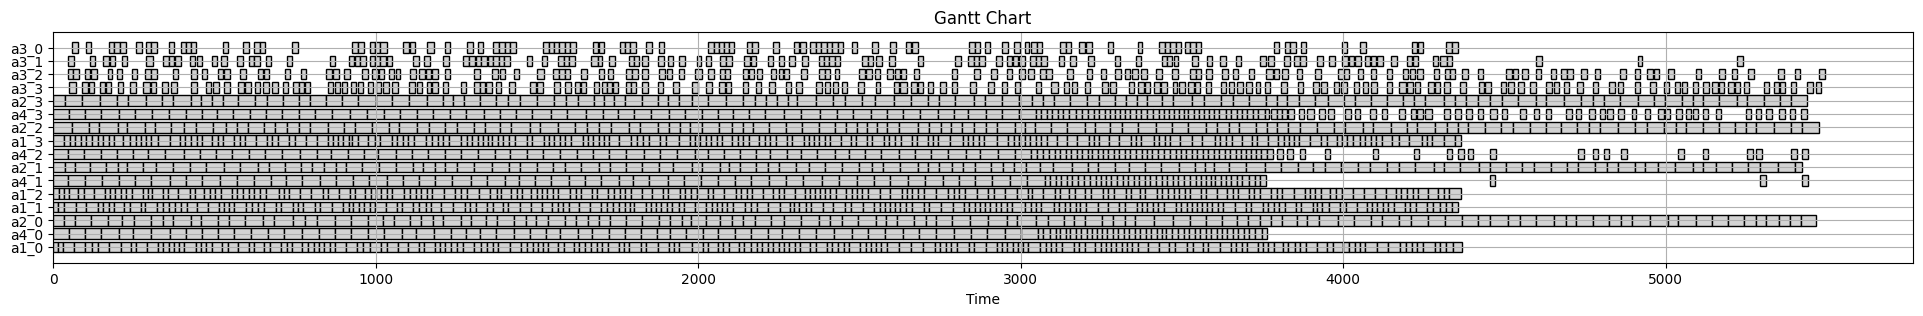

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import math

# Daten in ein DataFrame konvertieren
df = pd.DataFrame([p.to_dict() for p in gt_causal_schedule])

size_height = math.ceil(df["machine"].count().itemsize / 3)
# Gantt-Diagramm erstellen
fig, ax = plt.subplots(figsize=(24, size_height))

# Maschinen als y-Werte für die Balken
machines = df['machine'].unique()
machine_to_y = {machine: i for i, machine in enumerate(machines)}

# Iteriere über jede Zeile des DataFrames
for i, row in df.iterrows():
    start = row['start_time']
    duration = row['plan_duration']
    job_id = row['job_id']
    task_id = row['operation_id']
    machine = row['machine']
    label = f'{job_id} {task_id}'

    # Stelle die Aufgabe als Balken im Diagramm dar
    ax.barh(y=machine_to_y[machine], left=start, width=duration, height=0.8, align='center', color='lightgrey', edgecolor='black')
    
    # Text in den Balken einfügen
    #ax.text(x=start + duration / 2, y=machine_to_y[machine], s=label, va='center', ha='center', color='black')

# Diagramm formatieren
ax.set_xlabel('Time')
ax.set_yticks(list(machine_to_y.values()))
ax.set_yticklabels(list(machine_to_y.keys()))
ax.set_title('Gantt Chart')

# Grid anzeigen
ax.grid(True)

# Legende entfernen, da sie nicht mehr notwendig ist
# Handles und Labels der Legende deduplizieren
# handles, labels = plt.gca().get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys())

# Diagramm anzeigen
plt.show()
